In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno
import re

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

In [2]:
train_df = pd.read_csv('train.csv', sep = ',')
test_df = pd.read_csv('test.csv', sep = ',')

In [3]:
train_df.head()

PassengerId  Survived  Pclass   
0            1         0       3  \
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp   
0                            Braund, Mr. Owen Harris    male  22.0      1  \
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [4]:
total = train_df.isnull().sum().sort_values(ascending=False)
percent_1 = train_df.isnull().sum()/train_df.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

Total     %
Cabin          687  77.1
Age            177  19.9
Embarked         2   0.2
PassengerId      0   0.0
Survived         0   0.0

<Axes: >

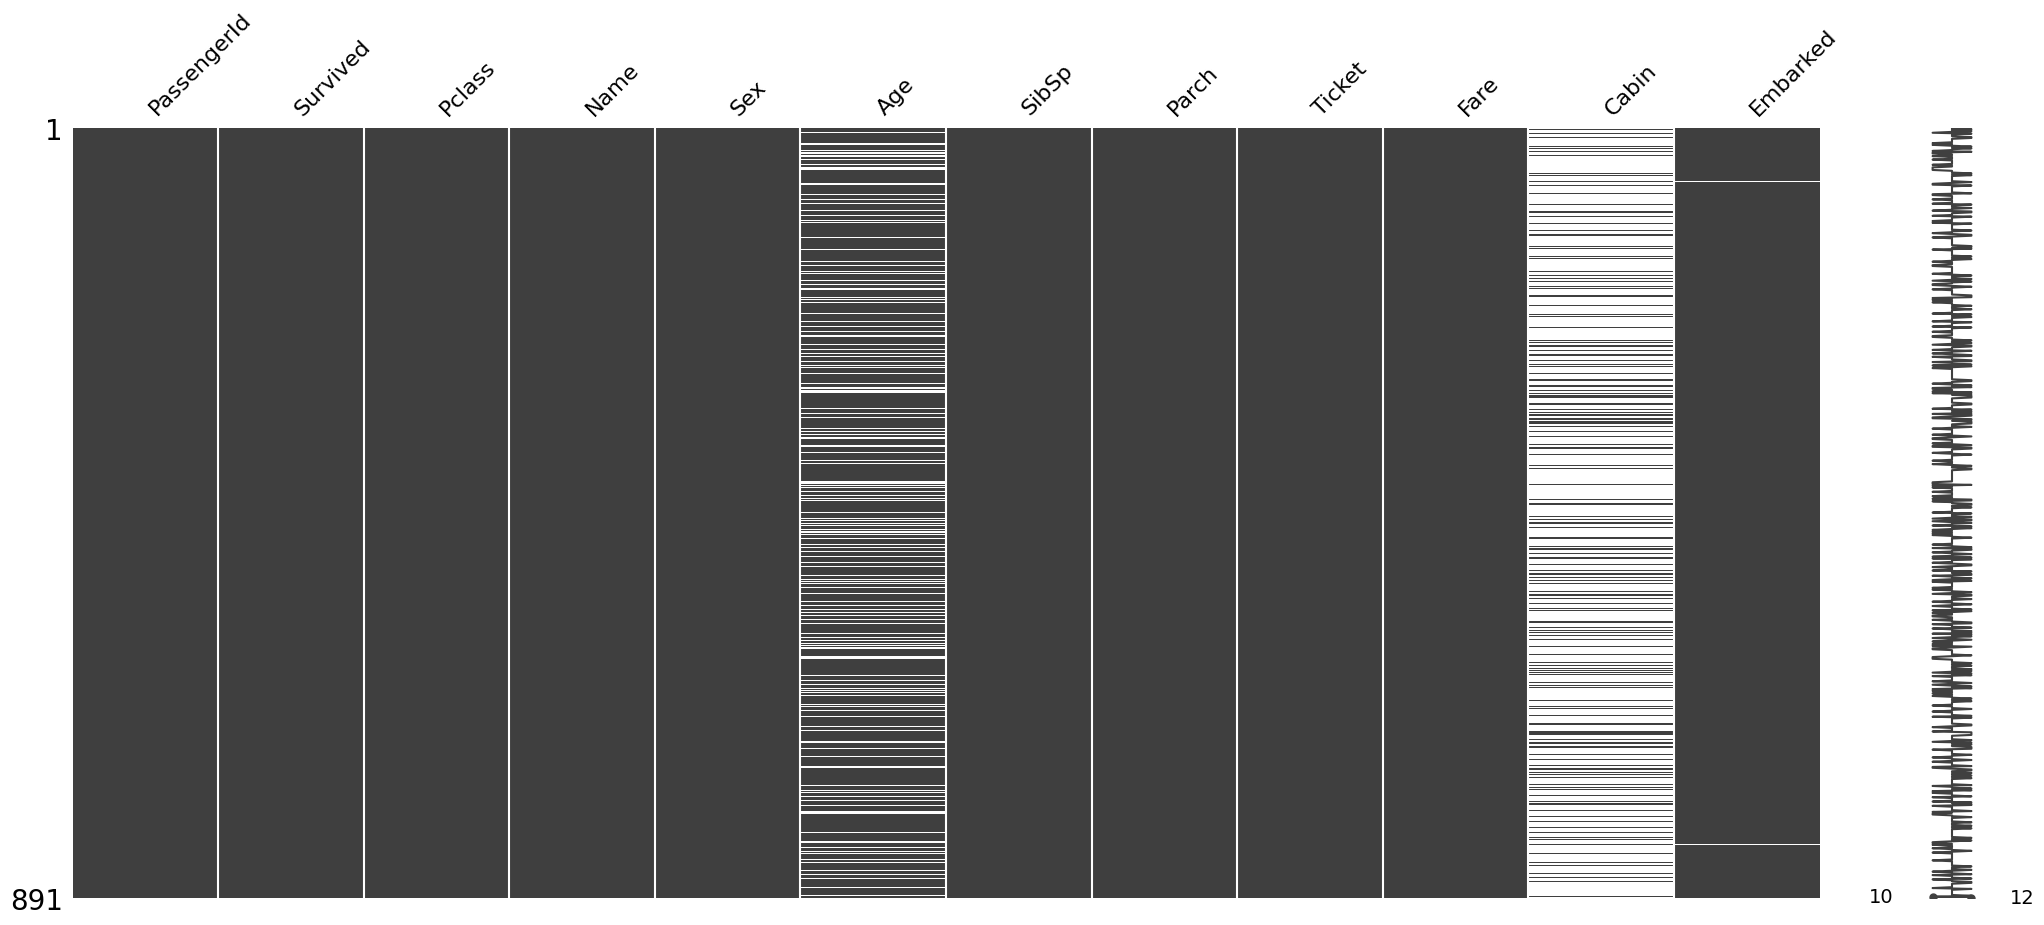

In [5]:
msno.matrix(train_df)

<Axes: >

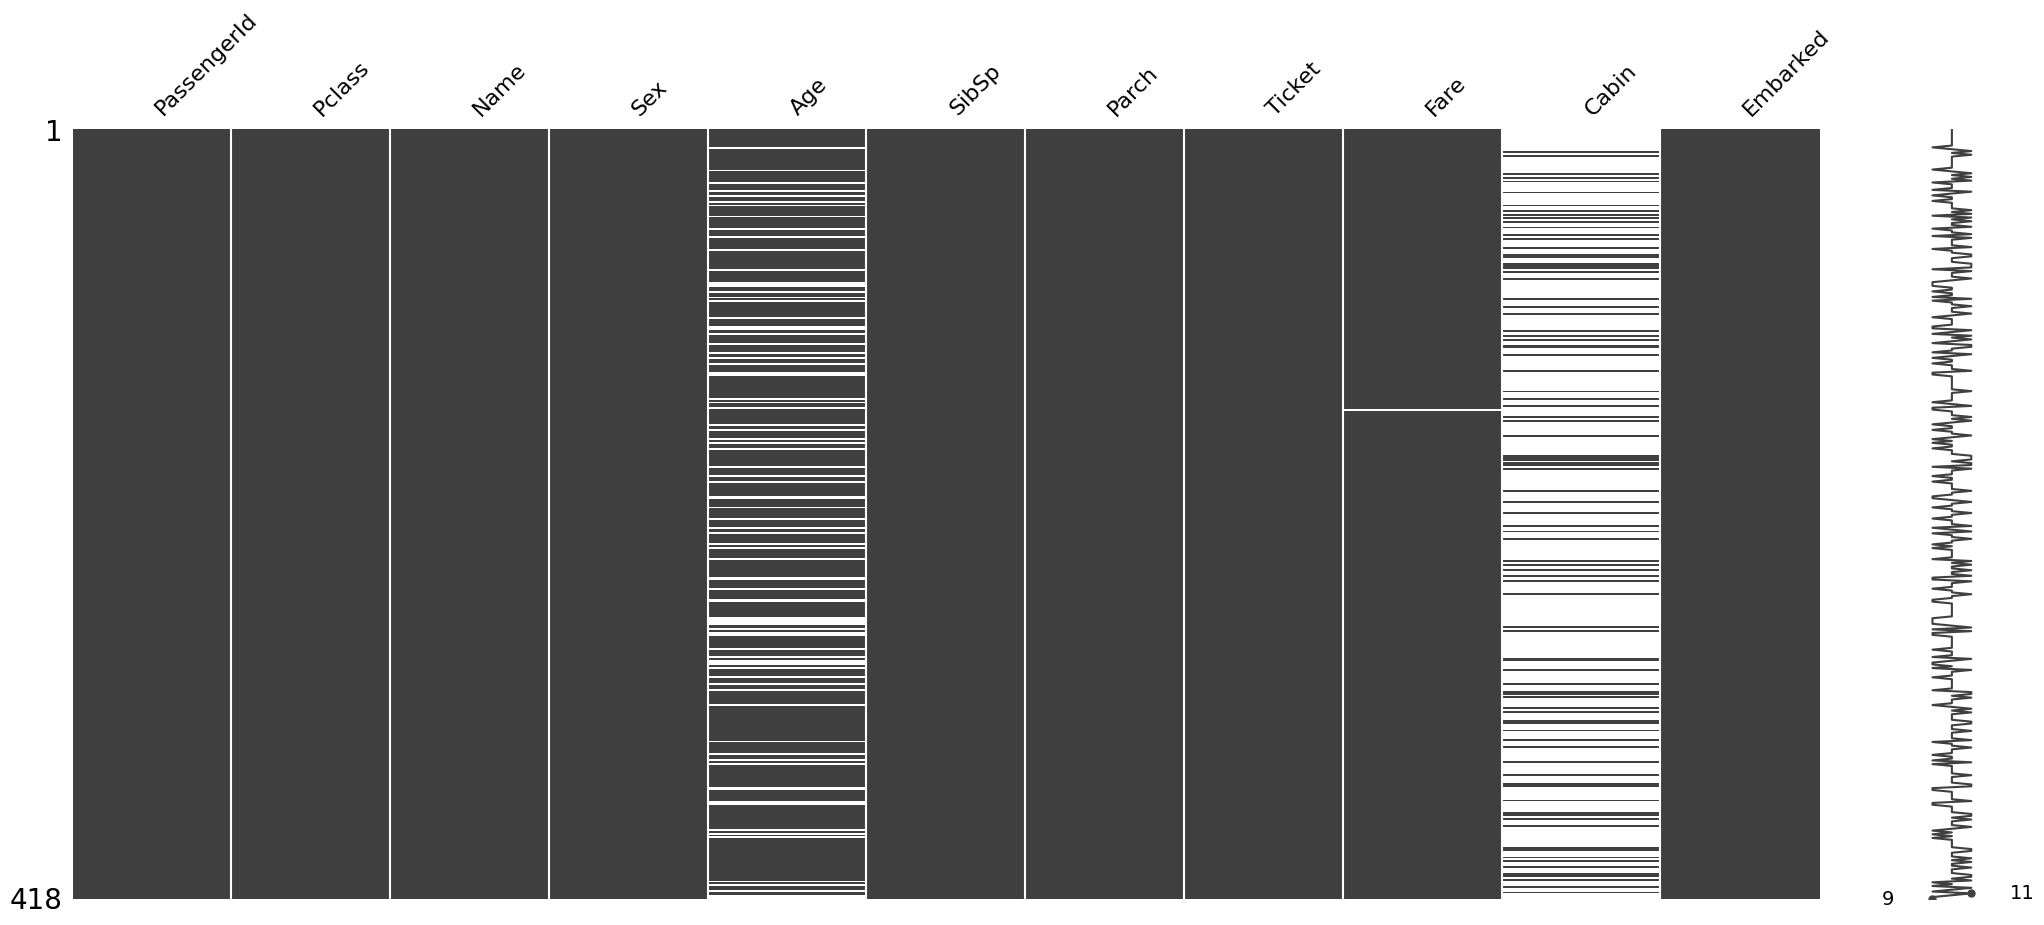

In [6]:
msno.matrix(test_df)

In [7]:
fig = sns.FacetGrid(train_df, col='Survived', aspect=2)

fig.map(sns.histplot, 'Age', bins=20, alpha=0.7)

fig.set(xlim=(0, train_df['Age'].max()))

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

survived = 'survived'
not_survived = 'not survived'

women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']

ax = sns.histplot(women[women['Survived']==1].Age.dropna(), bins=18, label=survived, ax=axes[0, 0], color='skyblue')
ax.set_title('Survival Distribution - Female (Survived)')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.legend()

ax = sns.histplot(women[women['Survived']==0].Age.dropna(), bins=40, label=not_survived, ax=axes[0, 1], color='salmon')
ax.set_title('Survival Distribution - Female (Not Survived)')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.legend()

ax = sns.histplot(men[men['Survived']==1].Age.dropna(), bins=18, label=survived, ax=axes[1, 0], color='skyblue')
ax.set_title('Survival Distribution - Male (Survived)')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.legend()

ax = sns.histplot(men[men['Survived']==0].Age.dropna(), bins=40, label=not_survived, ax=axes[1, 1], color='salmon')
ax.set_title('Survival Distribution - Male (Not Survived)')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.legend()

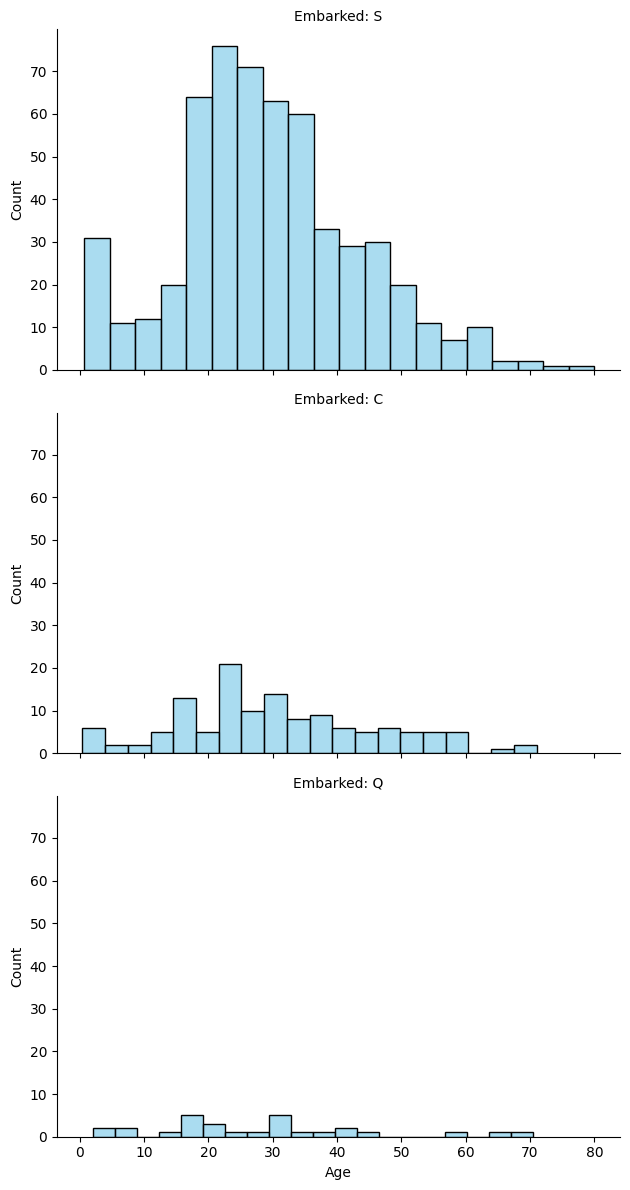

In [9]:
g = sns.FacetGrid(train_df, row='Embarked', aspect=1.6, height=4)

g.map(sns.histplot, 'Age', bins=20, color='skyblue', alpha=0.7)

g.set_titles('Embarked: {row_name}')
g.set_xlabels('Age')
g.set_ylabels('Count')

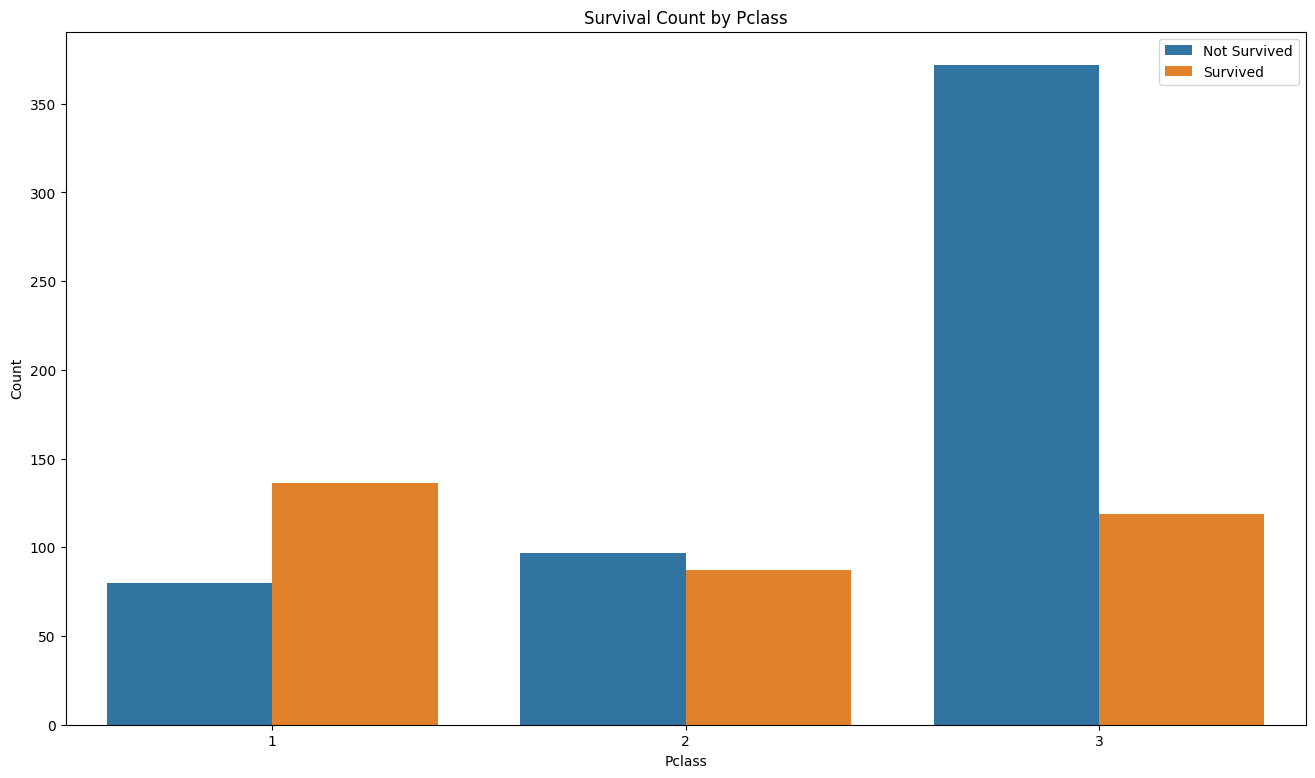

In [10]:
plt.figure(figsize=(16, 9))
sns.countplot(x='Pclass', hue='Survived', data=train_df)
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.title('Survival Count by Pclass')
plt.legend(['Not Survived', 'Survived'])

In [11]:
train_df.head()

train_df=train_df.drop(['Name'], axis = 1)
test_df=test_df.drop(['Name'], axis = 1)

In [12]:
train_df.head()

PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch   
0            1         0       3    male  22.0      1      0  \
1            2         1       1  female  38.0      1      0   
2            3         1       3  female  26.0      0      0   
3            4         1       1  female  35.0      1      0   
4            5         0       3    male  35.0      0      0   

             Ticket     Fare Cabin Embarked  
0         A/5 21171   7.2500   NaN        S  
1          PC 17599  71.2833   C85        C  
2  STON/O2. 3101282   7.9250   NaN        S  
3            113803  53.1000  C123        S  
4            373450   8.0500   NaN        S

In [13]:
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

train_df['Cabin'].fillna('U0', inplace=True)
test_df['Cabin'].fillna('U0', inplace=True)

train_df['Deck'] = train_df['Cabin'].apply(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
test_df['Deck'] = test_df['Cabin'].apply(lambda x: re.compile("([a-zA-Z]+)").search(x).group())

label_encoder = LabelEncoder()
train_df['Deck'] = label_encoder.fit_transform(train_df['Deck'])
test_df['Deck'] = label_encoder.transform(test_df['Deck'])

train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)


In [14]:
from sklearn.impute import SimpleImputer

data = [train_df, test_df]

for dataset in data:
    imputer = SimpleImputer(strategy='mean')
    age_values = dataset['Age'].values.reshape(-1, 1)
    dataset['Age'] = imputer.fit_transform(age_values)

    mean = train_df["Age"].mean()
    std = test_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    rand_age = np.random.randint(mean - std, mean + std, size=is_null)
    dataset.loc[np.isnan(dataset["Age"]), "Age"] = rand_age

    dataset['Age'] = dataset['Age'].astype(int)

In [15]:
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    int32  
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Embarked     891 non-null    object 
 10  Deck         891 non-null    int32  
dtypes: float64(1), int32(2), int64(5), object(3)
memory usage: 69.7+ KB


In [17]:
data = [train_df, test_df]

for dataset in data:
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    fare_values = dataset['Fare'].values.reshape(-1, 1)
    dataset['Fare'] = imputer.fit_transform(fare_values)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [18]:
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [19]:
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [20]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [21]:
train_df.head()

PassengerId  Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked  Deck
0            1         0       3    0   22      1      0     7         0     8
1            2         1       1    1   38      1      0    71         1     2
2            3         1       3    1   26      0      0     7         0     8
3            4         1       1    1   35      1      0    53         0     2
4            5         0       3    0   35      0      0     8         0     8

In [22]:
X_train = train_df.drop("Survived", axis=1)
X_test  = test_df
Y_train = train_df["Survived"]

In [24]:
train_x_clst = X_train
test_x_clst = X_test

In [25]:
perplexity_value = 50

C:\Users\User\AppData\Local\Temp\ipykernel_296536\1075887062.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_transform [:,0],tsne_transform [:,1], c='green', cmap='rainbow')


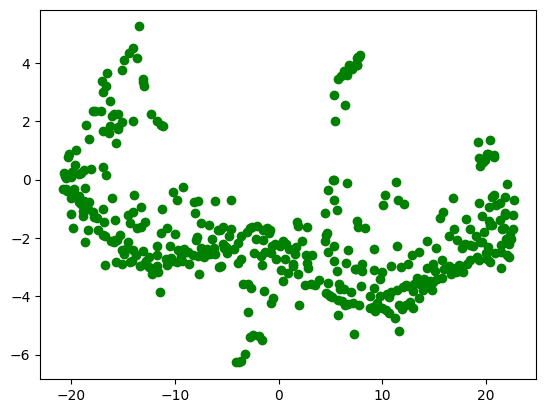

In [26]:
tsne = TSNE(perplexity=perplexity_value, 
            n_iter=1000, random_state=30)
tsne_transform = tsne.fit_transform(test_x_clst)
plt.scatter(tsne_transform [:,0],tsne_transform [:,1], c='green', cmap='rainbow')

In [27]:
clf = KMeans(n_clusters=2)
labels = clf.fit(tsne_transform).labels_
plt.scatter(tsne_transform[:,0],tsne_transform[:,1], c=labels, cmap='rainbow')

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
result_predi = clf.fit_predict(X_test)
results = pd.DataFrame()
results['PassengerId'] = test_df['PassengerId']
results['Survived'] = result_predi

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [29]:
results

PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         1
414         1306         1
415         1307         1
416         1308         1
417         1309         1

[418 rows x 2 columns]

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


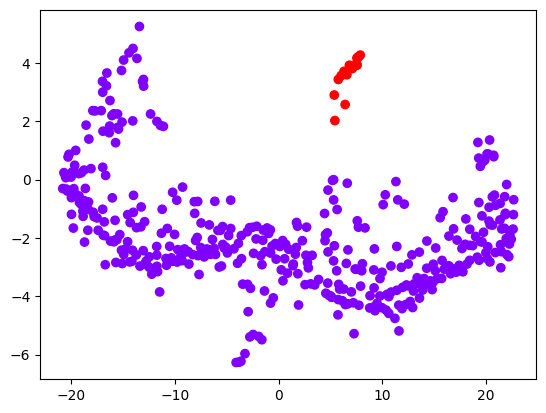

In [30]:
clf = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage="single")
labels = clf.fit(tsne_transform).labels_
plt.scatter(tsne_transform[:,0],tsne_transform[:,1], c=labels, cmap='rainbow')

In [31]:
result_predi = clf.fit_predict(X_test)
results = pd.DataFrame()
results['PassengerId'] = test_df['PassengerId']
results['Survived'] = result_predi

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [32]:
results

PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         0
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


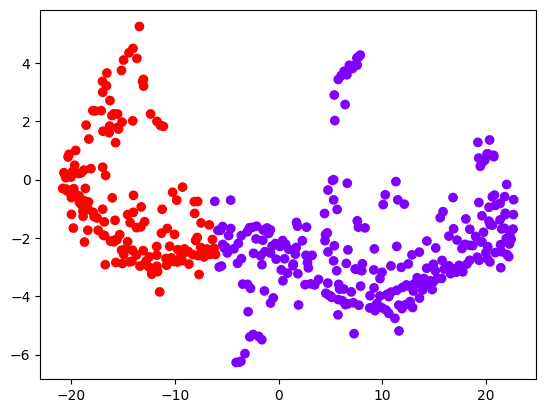

In [33]:
clf = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage="complete")
labels = clf.fit(tsne_transform).labels_
plotter(tsne_transform, labels)

In [34]:
result_predi = clf.fit_predict(X_test)
results = pd.DataFrame()
results['PassengerId'] = test_df['PassengerId']
results['Survived'] = result_predi

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [35]:
results

PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         0
415         1307         0
416         1308         0
417         1309         0

[418 rows x 2 columns]